### Import libraries and data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.
from sklearn.preprocessing import StandardScaler


In [3]:
#creating path
path = r"C:\Users\Sreelaya Narla\Desktop\Achievement 6\chocolate bar ratings analysis"

In [4]:
# Import data

df = pd.read_csv(os.path.join(path, '02 data', 'prepared data', 'cleaned_flavors_of_cacao.csv'))

### data cleaning

In [5]:
df.columns

Index(['Company_(Maker-if_known)', 'Specific_Bean_Origin_or_Bar_Name', 'REF',
       'Review_Date', 'Cocoa_Percent', 'Company_Location', 'Rating',
       'Bean_Type', 'Broad_Bean_Origin'],
      dtype='object')

In [6]:
# Drop columns not used in EDA
for col in ['REF', 'Specific_Bean_Origin_or_Bar_Name' ]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [7]:
#Now rename the cleaned header
df.rename(columns={'Company_(Maker-if_known)' : 'Company'}, inplace=True)
df.columns.tolist()

['Company',
 'Review_Date',
 'Cocoa_Percent',
 'Company_Location',
 'Rating',
 'Bean_Type',
 'Broad_Bean_Origin']

In [8]:
# Rename 'Broad_Bean_Origin' to Country to match GeoJSON 
df = df.rename(columns={'Broad_Bean_Origin':'Country'})

In [9]:
df.head()

,Company,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Country
0,A. Morin,2016,63.0,France,3.75,Unknown,Sao Tome
1,A. Morin,2015,70.0,France,2.75,Unknown,Togo
2,A. Morin,2015,70.0,France,3.00,Unknown,Togo
3,A. Morin,2015,70.0,France,3.50,Unknown,Togo
4,A. Morin,2015,70.0,France,3.50,Unknown,Peru


In [10]:
# Keep only numerical variables
df_num = df.select_dtypes(include=[np.number]).copy()

df_num.head()

,Review_Date,Cocoa_Percent,Rating
0,2016,63.0,3.75
1,2015,70.0,2.75
2,2015,70.0,3.00
3,2015,70.0,3.50
4,2015,70.0,3.50


In [11]:
#Because k-means is sensitive to scale differences.
#Standardize the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)
df_scaled.head()

,Review_Date,Cocoa_Percent,Rating
0,1.255692,-1.376022,1.180231
1,0.913975,-0.268665,-0.912129
2,0.913975,-0.268665,-0.389039
3,0.913975,-0.268665,0.657141
4,0.913975,-0.268665,0.657141


### Elbow method to choose k

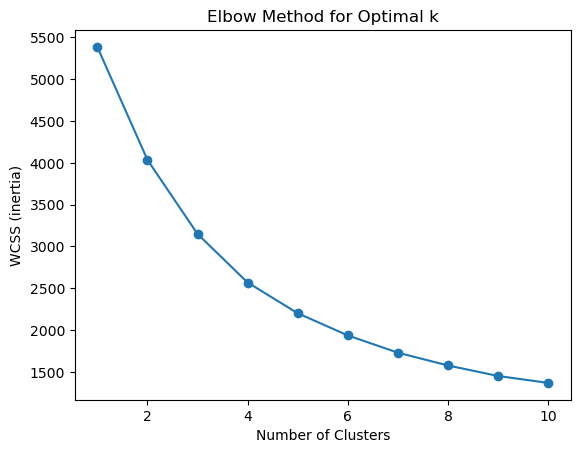

In [12]:
wcss = []  # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()


There’s a sharp drop from k=1 to k=3.

After k=3, the curve starts flattening — meaning adding more clusters doesn’t reduce inertia much.

 That suggests the optimal k is 3.

### k-means clustering

In [13]:
# Run KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Preview the dataframe with clusters
df.head()

,Company,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Country,Cluster
0,A. Morin,2016,63.0,France,3.75,Unknown,Sao Tome,0
1,A. Morin,2015,70.0,France,2.75,Unknown,Togo,0
2,A. Morin,2015,70.0,France,3.00,Unknown,Togo,0
3,A. Morin,2015,70.0,France,3.50,Unknown,Togo,0
4,A. Morin,2015,70.0,France,3.50,Unknown,Peru,0


In [14]:
df.to_csv(os.path.join(path, '02 data', 'prepared data', 'c-clusters.csv'), index=False)

In [15]:
df['Cluster'].value_counts()

Cluster
0    915
1    522
2    358
Name: count, dtype: int64

In [16]:
# Descriptive stats by cluster
cluster_stats = df.groupby('Cluster')[['Review_Date', 'Cocoa_Percent', 'Rating']].mean()
print(cluster_stats)

# Also include counts
cluster_counts = df['Cluster'].value_counts()
print("\nCluster counts:\n", cluster_counts)

         Review_Date  Cocoa_Percent    Rating
Cluster                                      
0        2014.359563      70.519126  3.322951
1        2009.022989      68.875479  3.302682
2        2011.941341      78.828212  2.665503

Cluster counts:
 Cluster
0    915
1    522
2    358
Name: count, dtype: int64


Chocolates with very high cocoa % (>75%) tend to cluster together and generally receive lower ratings (Cluster 2).

More recently reviewed chocolates with moderate cocoa % (around 70%) perform better in ratings (Cluster 0).

Older reviews (around 2009) with lower cocoa % are in Cluster 1, and their ratings are similar to Cluster 0 but not as recent.

This shows that cocoa % and review year both matter for how chocolates are rated.

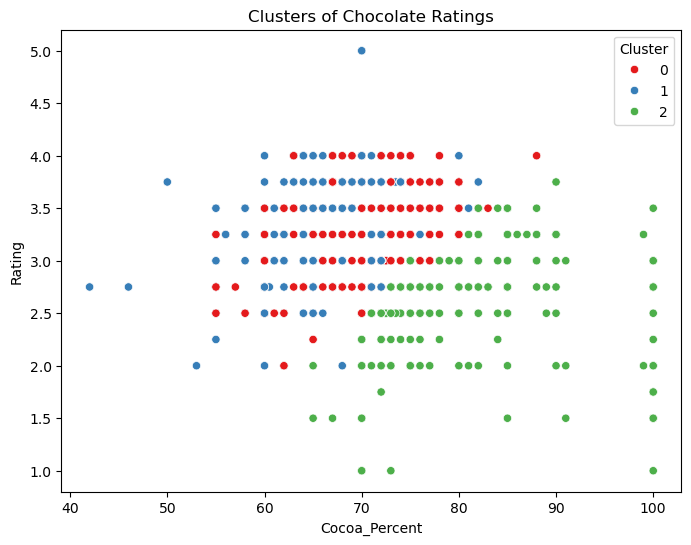

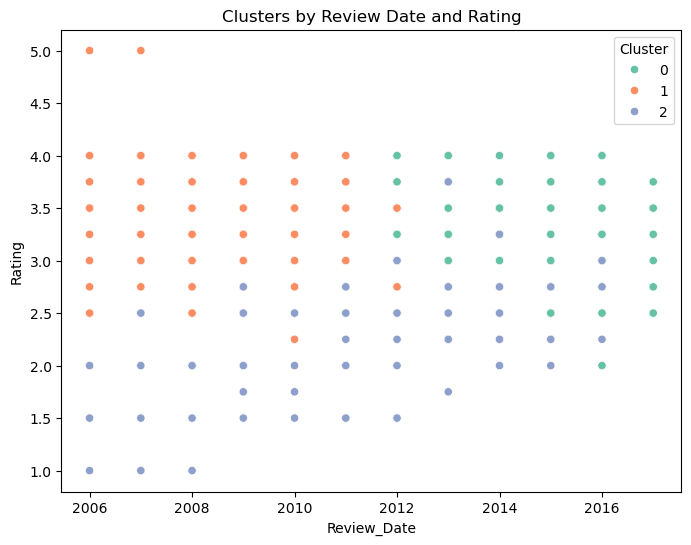

In [17]:
# Scatterplot: Rating vs Cocoa_Percent
plt.figure(figsize=(8,6))
sns.scatterplot(x='Cocoa_Percent', y='Rating', hue='Cluster', data=df, palette='Set1')
plt.title('Clusters of Chocolate Ratings')
plt.show()

# Scatterplot: Review_Date vs Rating
plt.figure(figsize=(8,6))
sns.scatterplot(x='Review_Date', y='Rating', hue='Cluster', data=df, palette='Set2')
plt.title('Clusters by Review Date and Rating')
plt.show()


### Interpretation of Clusters

#### Cocoa % vs Rating (Top Plot)

Cluster 2 (green dots) groups chocolates with very high cocoa % (75–100%). These tend to receive lower ratings, suggesting that higher cocoa content might not always be appreciated by reviewers.

Cluster 0 (red dots) sits around 65–72% cocoa with average-to-high ratings. This seems to be a "sweet spot" for consumer preference.

Cluster 1 (blue dots) covers a wider cocoa % range (55–70%) but is more mixed in ratings, indicating more variability.

 Insight: Chocolates with moderate cocoa content are more likely to get better ratings, while very dark chocolates (high cocoa %) tend to get lower scores.

#### Review Date vs Rating (Bottom Plot)

Cluster 1 (orange dots) dominates earlier reviews (2006–2010). Ratings in this period are spread across the full scale, from low to high.

Cluster 2 (blue dots) appears more often in mid-to-later years (2010–2014) and contains many lower ratings.

Cluster 0 (green dots) appears mostly in later reviews (2013–2016), where ratings are more consistently above 3.0.

 Insight: Over time, reviewers may have become more consistent, with recent reviews showing clearer patterns (high cocoa = low ratings, moderate cocoa = higher ratings).

What These Clusters Tell Us

Cluster 0: Modern, moderately dark chocolates (≈70% cocoa) with good ratings → these are likely popular among consumers.

Cluster 1: Older reviews with mixed cocoa % and ratings → these may reflect more experimental or inconsistent chocolate quality in earlier years.

Cluster 2: High-cocoa chocolates (>75%) with lower ratings → while some consumers may like them, on average they’re not rated as highly.

### Clustering Results: Descriptive Statistics & Interpretation

After applying k-means clustering with **k = 3** (chosen using the elbow method, where the WCSS curve started to flatten at 3 clusters), the clusters revealed the following characteristics:

| Cluster | Count | Avg. Review Year | Avg. Cocoa % | Avg. Rating |
|---------|-------|------------------|--------------|-------------|
| 0       | 915   | 2014.36          | 70.52%       | 3.32        |
| 1       | 522   | 2009.02          | 68.88%       | 3.30        |
| 2       | 358   | 2011.94          | 78.83%       | 2.67        |

#### Key Findings
- **Cluster 0 (Modern chocolates, post-2013):**
  - Average cocoa ~70.5%
  - Ratings are slightly above average (3.32).
  - Represents recent chocolates, showing a balanced preference for around 70% cocoa.

- **Cluster 1 (Older chocolates, pre-2010):**
  - Average cocoa ~68.9%
  - Ratings similar to Cluster 0 (3.30).
  - Represents earlier reviews, suggesting consumer preferences for ~70% cocoa are consistent over time.

- **Cluster 2 (High cocoa, ~79%):**
  - Highest cocoa content, but lowest ratings (2.67).
  - Indicates that very dark chocolates are less well-received overall, likely appealing to a smaller niche audience.

#### Insights & Future Applications
- **Marketing Strategy:** Focus promotions on chocolates around **70% cocoa** (Clusters 0 & 1), as these consistently achieve higher ratings. Position **very dark chocolates** (Cluster 2) as a premium or niche product for enthusiasts.
- **Product Development:** Recipe optimization should target the 68–72% cocoa range, where consumer satisfaction is highest.
- **Trend Analysis:** Monitor if preferences shift toward darker chocolates over time, as Cluster 0 suggests a slight upward shift compared to Cluster 1.
- **Customer Segmentation:** If demographic data becomes available, link clusters to customer profiles (e.g., age, region) to refine marketing.

In conclusion, clustering highlights that while chocolates with ~70% cocoa dominate consumer preferences, there is a clear distinction for high-cocoa products that could be strategically marketed to a smaller, dedicated audience.


In [18]:
cluster_summary = df.groupby('Cluster')[['Review_Date','Cocoa_Percent','Rating']].agg(['mean','count']).reset_index()
cluster_summary.columns = ['_'.join(col).strip('_') for col in cluster_summary.columns.values]
cluster_summary.to_csv(os.path.join(path, '02 data', 'prepared data', 'cluster_summary.csv'), index=False)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Sreelaya Narla\\Desktop\\Achievement 6\\chocolate bar ratings analysis\\02 data\\prepared data\\cluster_summary.csv'